# CS146 Final Project
## Modeling and forecasting atmospheric CO₂ from 1958 into the future
### Jasen Lo

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts
import seaborn as sns; sns.set()
import random as random


data = pd.read_csv("weekly_in_situ_co2_mlo.csv",skiprows = 44, 
                   names = ['Date','CO2'], parse_dates=['Date'])

#Add number of days since measurements started to the data since we use that in
#our model to account for seasonal variation
data['Days'] = pd.Series(data=[(x-data['Date'][0]).days for x in data['Date']])
data.head()

,Date,CO2,Days
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


In [291]:
#Preparing future data prediction dates
pred_Date = pd.date_range("2020-02-29", "2060-01-5", freq='W-FRI')
pred_df = pd.DataFrame({'Predicted Date':pred_Date})

future_n = len(pred_df)

pred_df['Predicted Day'] = pd.Series(data=[(x-pred_df['Predicted Date'][0]).days + 22617 for x in pred_df['Predicted Date']])
print("Number of Current Data Points", len(data))
print("Number of New Data Points:", future_n)

Number of Current Data Points 3160
Number of New Data Points: 2079


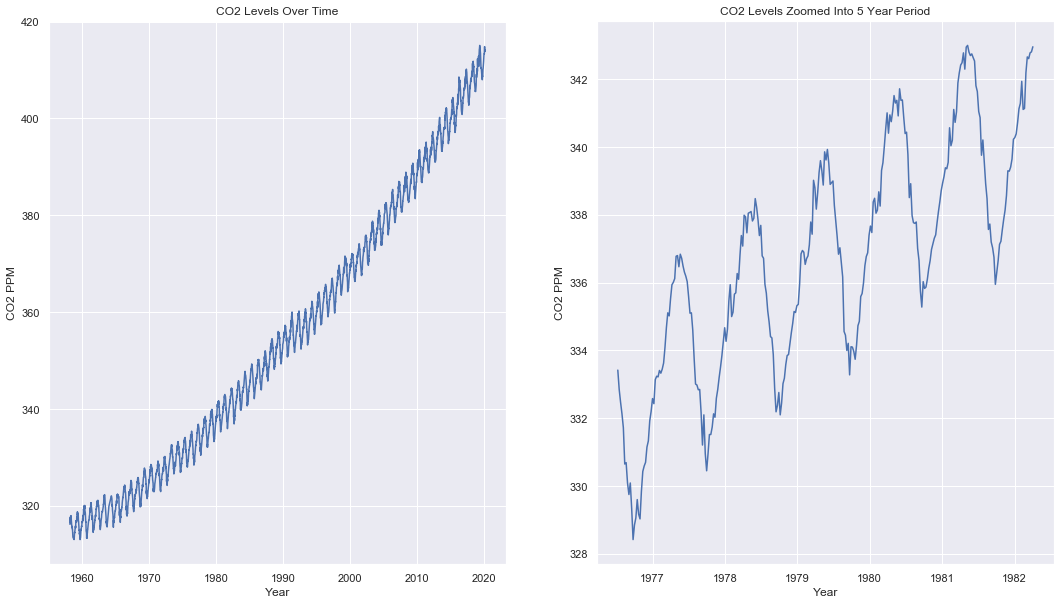

In [552]:
date = data['Date'].values
new_date = pred_Date

day = data['Days'].values
new_day = pred_df['Predicted Day'].values

CO2 = data['CO2'].values

#Plot all data


fig1 = plt.figure(figsize=(18,10))

plt.subplot(1, 2, 1)
plt.plot(date,CO2)
plt.title('CO2 Levels Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.subplot(1, 2, 2)
plt.plot(date[900:1200],CO2[900:1200])
plt.title('CO2 Levels Zoomed Into 5 Year Period')
plt.xlabel('Year')
plt.ylabel('CO2 PPM')
plt.show()

fig1.savefig('fig1')

### Modelling Overall Trend of Atmospheric CO2 Over Time

In [276]:
stan_data_trend = {
    "n_data" : len(data),
    'n_future': future_n,
    "time" : day,
    "time_future" : new_day,
    "CO2" : CO2
}

In [542]:
linear = """
data {
    int<lower=0> n_data;             // number of data
    int<lower=0> time[n_data];      // days since measurement start
    
    real<lower=0> CO2[n_data];      // measured ppm
    
    int<lower=0> n_future;             // number of future data
    int<lower=0> time_future[n_future];      // days since measurement start
    
}
parameters {
    real<lower=0> c0;    // 'intercept' so to speak       
    real<lower=0> c1;    // linear coefficient
    real<lower=0> c4;    // noise - sigma^2.
}

model {
 
    // Priors
    c0 ~ normal(315, 50); 
    c1 ~ cauchy(0,1);
    c4 ~ cauchy(0,1);
    
    for (i in 1:n_data) {
        CO2[i] ~ normal(c0 + c1*time[i], c4); 
    }
}

generated quantities {

    real CO2_pred[n_future];
    for (i in 1:n_future) {
        CO2_pred[i] = normal_rng(c0 + c1*time_future[i], c4); 
    }
}

"""


quadratic = """
data {
    int<lower=0> n_data;             // number of data
    int<lower=0> time[n_data];      // days since measurement start
    
    real<lower=0> CO2[n_data];      // measured ppm
    
    int<lower=0> n_future;             // number of future data
    int<lower=0> time_future[n_future];      // days since measurement start
    
}

parameters {
    real<lower=0> c0;    // 'intercept' so to speak       
    real<lower=0> c1;    // linear coefficient
    real<lower=0> c2;    // quadratic coefficient
    real<lower=0> c4;    // noise - sigma^2.
}

model {
 
    // Priors
    c0 ~ normal(315, 50); 
    c1 ~ cauchy(0,1);
    c2 ~ cauchy(0,1);
    c4 ~ cauchy(0,1);
    
    
    for (i in 1:n_data) {
        CO2[i] ~ normal(c0 + c1*time[i] + c2*(time[i]^2), c4); 
    }
}

generated quantities {
    real CO2_pred[n_future];
    for (i in 1:n_future) {
        CO2_pred[i] = normal_rng(c0 + c1*time_future[i] + c2*(time_future[i]^2), c4); 
    }
}


"""


linear_model = pystan.StanModel(model_code=linear)
quadratic_model = pystan.StanModel(model_code=quadratic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cfc7cb1682b17c3dbf499c0b87b18011 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8dae834dccdcaf164bb7ffc8430d7f04 NOW.


In [278]:
linear_results = linear_model.sampling(data=stan_data_trend, iter=2000)
linear_parameters = ['c0', 'c1','c4']

print(linear_results.stansummary(pars=linear_parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_b8aabb897b40c2ce3fc0cd9b7d910071.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 305.95  3.5e-3   0.16 305.65 305.85 305.96 306.06 306.25   1936    1.0
c1 4.3e-3  2.9e-7 1.2e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   1620    1.0
c4   4.31  1.5e-3   0.05    4.2   4.27   4.31   4.34   4.42   1305    1.0

Samples were drawn using NUTS at Thu Apr 23 00:48:28 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [279]:
quadratic_results = quadratic_model.sampling(data=stan_data_trend, iter=2000)
quadratic_parameters = ['c0', 'c1','c2','c4']
print(quadratic_results.stansummary(pars=quadratic_parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_8dae834dccdcaf164bb7ffc8430d7f04.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
c0 314.59  3.0e-3   0.12 314.34  314.5 314.59 314.67  314.83   1680    1.0
c1 2.1e-3  6.5e-7 2.5e-5 2.0e-3 2.1e-3 2.1e-3 2.1e-3  2.1e-3   1435    1.0
c2 9.8e-8 2.7e-11 1.0e-9 9.5e-8 9.7e-8 9.8e-8 9.8e-8 10.0e-8   1480    1.0
c4   2.25  8.5e-4   0.03   2.19   2.23   2.25   2.27    2.31   1148    1.0

Samples were drawn using NUTS at Thu Apr 23 00:49:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


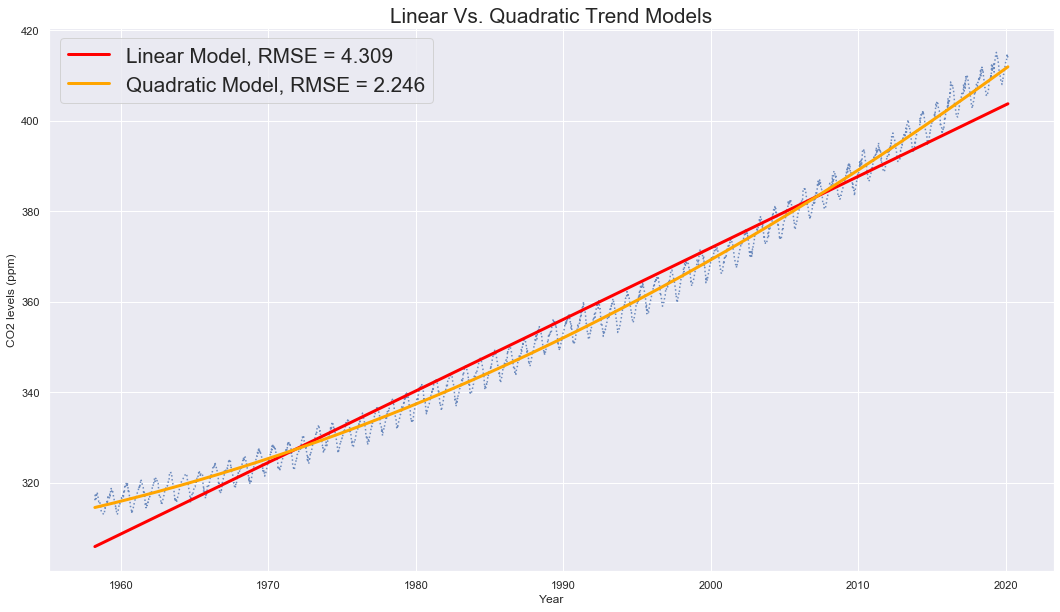

In [297]:
#extract samples of parameter values from Stan sampling
linear_samples = linear_results.extract()
quadratic_samples = quadratic_results.extract()

#find estimates of CO2 from Stan parameter samples
linear_estimate = linear_samples['c0'].mean() +\
                  linear_samples['c1'].mean()*day

quadratic_estimate = quadratic_samples['c0'].mean() +\
                     quadratic_samples['c1'].mean()*day +\
                     quadratic_samples['c2'].mean()*day**2

#calculate RMSE using residuals to judge model fit
linear_residuals = CO2 - linear_estimate
quadratic_residuals = CO2 - quadratic_estimate

#these residuals will later be used to estimate the fit 
CO2_noTrend = quadratic_residuals

linear_RMSE = np.sqrt(np.mean(linear_residuals**2))
quadratic_RMSE = np.sqrt(np.mean(quadratic_residuals**2))

plt.figure(figsize=(18,10))

#plot data
plt.plot(date, CO2, alpha=0.8, linestyle=':')

#plot linear model estimates
plt.plot(date, linear_estimate, color="red", 
         label = "Linear Model, RMSE = {:.3f}".format(linear_RMSE), linewidth=3)

#plot quadratic model estimates
plt.plot(date, quadratic_estimate, color="orange", 
         label = "Quadratic Model, RMSE = {:.3f}".format(quadratic_RMSE), linewidth=3)

plt.title("Linear Vs. Quadratic Trend Models", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO2 levels (ppm)')
plt.legend(fontsize = "xx-large")
plt.show()

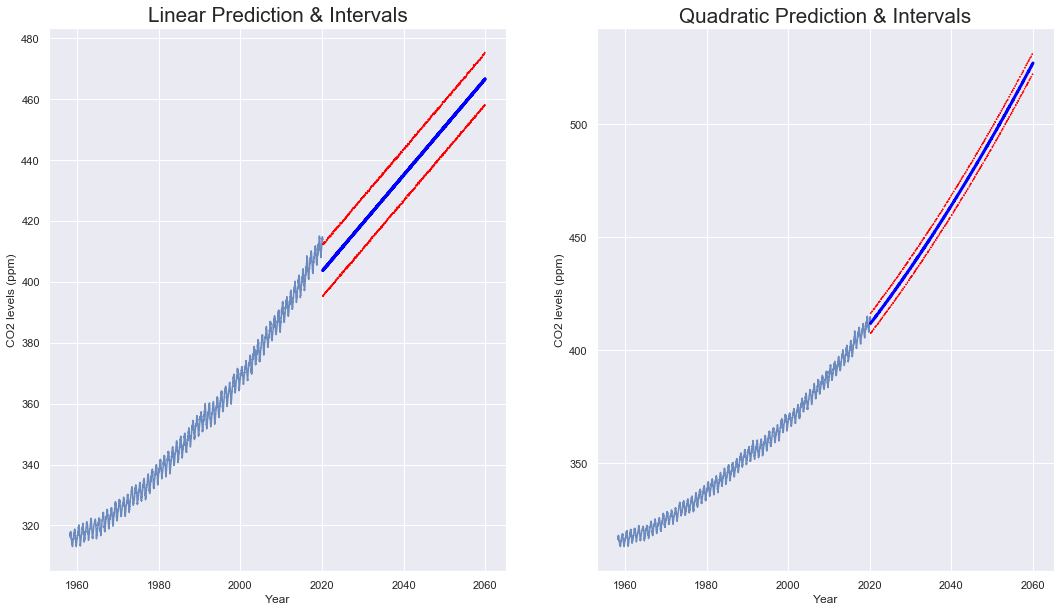

In [411]:
#Plot predictions and intervals
linear_prediction = []
for i in linear_samples['CO2_pred'].transpose():
    linear_prediction.append(np.mean(i))
    
quadratic_prediction = [] 
for i in quadratic_samples['CO2_pred'].transpose():
    quadratic_prediction.append(np.mean(i))
    
linear_prediction_interval = np.percentile(linear_samples['CO2_pred'], axis=0, q=[2.5, 97.5])
quadratic_prediction_interval = np.percentile(quadratic_samples['CO2_pred'], axis=0, q=[2.5, 97.5])

plt.figure(figsize=(18,10))
plt.subplot(1, 2, 1)

#plot data
plt.plot(date, data.CO2, alpha=0.8)

#plot linear model predictions
plt.plot(new_date, linear_prediction, color="blue",linewidth=3)

#plot linear model intervals
plt.plot(new_date, linear_prediction_interval[0,:], color="red", linestyle=':')
plt.plot(new_date, linear_prediction_interval[1,:], color="red", linestyle=':')

plt.title("Linear Prediction & Intervals", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO2 levels (ppm)')


plt.subplot(1, 2, 2)
#plot data
plt.plot(date, data.CO2, alpha=0.8)

#plot quadratic model predictions
plt.plot(new_date, quadratic_prediction, color="blue", linewidth=3)

#plot quadratic model intervals
plt.plot(new_date, quadratic_prediction_interval[0,:], color="red", linestyle=':')
plt.plot(new_date, quadratic_prediction_interval[1,:], color="red", linestyle=':')

plt.title("Quadratic Prediction & Intervals", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO2 levels (ppm)')

plt.show()

### Modelling Seasonal Variation of Atmosphereic CO2

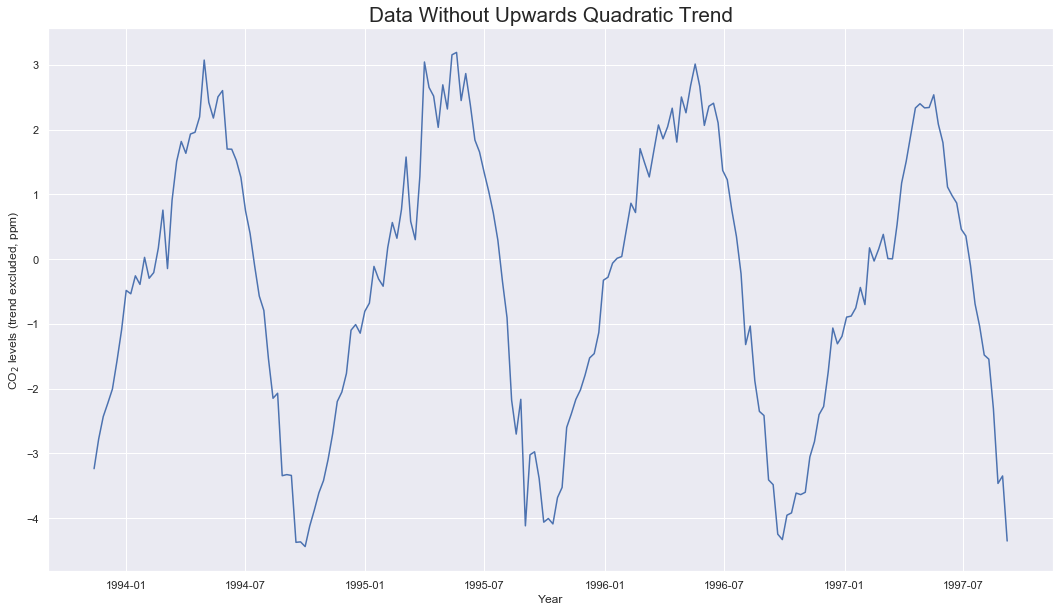

In [300]:
fig5 = plt.figure(figsize=(18,10))
plt.plot(date[1800:2000], CO2_noTrend[1800:2000])
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (trend excluded, ppm)')
plt.title("Data Without Upwards Quadratic Trend", fontsize = "xx-large")

plt.show()

In [304]:
stan_data_seasonal = {
    "n_data" : len(data),
    'n_future': future_n,
    "time" : day,
    "time_future" : new_day,
    "CO2" : CO2_noTrend
}

In [398]:
cosine = """
data {
    int<lower=0> n_data;             // number of data
    int<lower=0> time[n_data];      // days since measurement start
    
    real CO2[n_data];      // measured ppm
    
    int<lower=0> n_future;             // number of future data
    int<lower=0> time_future[n_future];      // days since measurement start
    
}


parameters {
    real<lower=0> c2;                      // amplitude     
    real<lower=0> c4;            // noise or sigma^2.
    
   
    unit_vector[2] phi;         // We need a periodic phi/phase
}

transformed parameters {
    real c3 = atan2(phi[1],phi[2]);
}

model {
 
    // Priors
    c2 ~ normal(2, 2);  //#(0,4)
    c4 ~ cauchy(0,1);    

    for(i in 1:n_data) {
        CO2[i] ~  normal(c2*cos(2*pi()*time[i]/365.25 + c3), c4);   //likelihood function 
  }
}

generated quantities {
    real CO2_pred[n_future];
    for (i in 1:n_future) {
        CO2_pred[i] = normal_rng(c2*cos(2*pi()*time_future[i]/365.25 + c3), c4); 
    }
}

"""

sine = """
data {
    int<lower=0> n_data;             // number of data
    int<lower=0> time[n_data];      // days since measurement start
    
    real CO2[n_data];      // measured ppm
    
    int<lower=0> n_future;             // number of future data
    int<lower=0> time_future[n_future];      // days since measurement start
    
}


parameters {
    real<lower=0> c2;                      // amplitude     
    real<lower=0> c4;            // noise or sigma^2.
    
   
    unit_vector[2] phi;         // We need a periodic phi/phase
}

transformed parameters {
    real c3 = atan2(phi[1],phi[2]);
}

model {
 
    // Priors
    c2 ~ normal(2, 2); 
    c4 ~ cauchy(0,1);    

    for(i in 1:n_data) {
        CO2[i] ~  normal(c2*sin(2*pi()*time[i]/365.25 + c3), c4);   //likelihood function 
  }
}

generated quantities {
    real CO2_pred[n_future];
    for (i in 1:n_future) {
        CO2_pred[i] = normal_rng(c2*sin(2*pi()*time_future[i]/365.25 + c3), c4); 
    }
}

"""


In [399]:
cosine_model = pystan.StanModel(model_code=cosine)
sine_model = pystan.StanModel(model_code= sine)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_712e77c3a1ee585c7c7bc09b45479322 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9dca83ccade31dca3a2c70e5e11352aa NOW.


In [400]:
cosine_results = cosine_model.sampling(data=stan_data_seasonal, iter=2000, 
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999})

cosine_parameters = ['c2', 'c3','c4']
print(cosine_results.stansummary(pars=cosine_parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_712e77c3a1ee585c7c7bc09b45479322.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2   2.85  5.7e-4   0.02    2.8   2.84   2.85   2.87    2.9   1905    1.0
c3  -0.41  1.4e-4 8.7e-3  -0.43  -0.42  -0.41   -0.4  -0.39   4004    1.0
c4   0.99  2.9e-4   0.01   0.97   0.98   0.99    1.0   1.02   1756    1.0

Samples were drawn using NUTS at Thu Apr 23 15:56:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [401]:
sine_results = sine_model.sampling(data=stan_data_seasonal, iter=2000, 
                              control={'max_treedepth': 12, 'adapt_delta' : 0.9999})

sine_parameters = ['c2', 'c3','c4']
print(sine_results.stansummary(pars=sine_parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_9dca83ccade31dca3a2c70e5e11352aa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2   2.85  5.7e-4   0.03   2.81   2.83   2.85   2.87    2.9   1923    1.0
c3   1.16  1.4e-4 8.6e-3   1.14   1.15   1.16   1.17   1.18   3961    1.0
c4   0.99  2.7e-4   0.01   0.97   0.98   0.99    1.0   1.02   2109    1.0

Samples were drawn using NUTS at Thu Apr 23 16:07:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


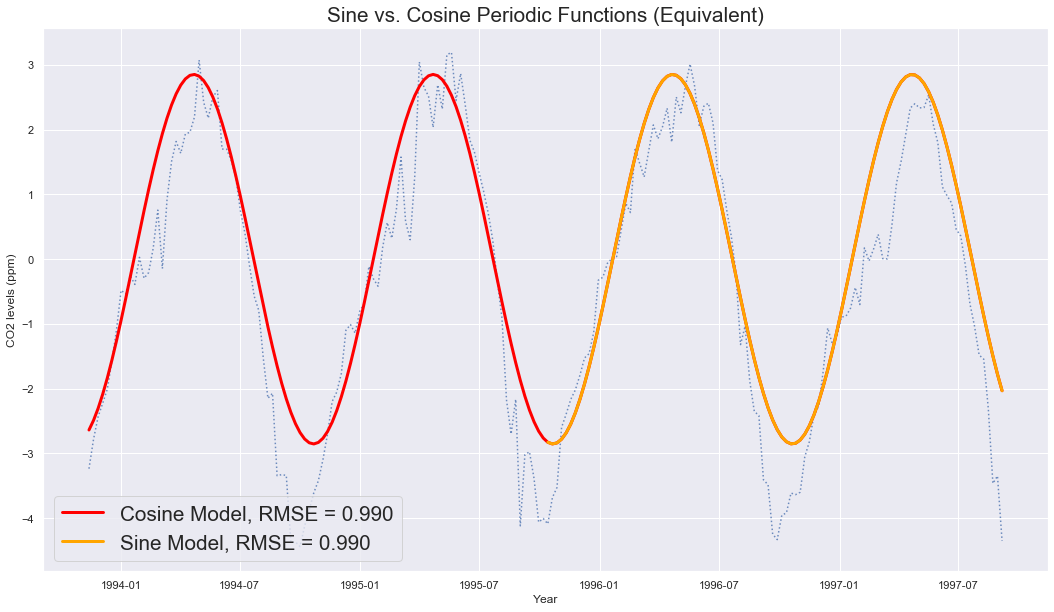

In [407]:
cosine_samples = cosine_results.extract()
sine_samples = sine_results.extract()

cosine_estimate = cosine_samples['c2'].mean() * np.cos(2*np.pi*day/365.25 + 
                                                       cosine_samples['c3'].mean())

sine_estimate = sine_samples['c2'].mean() * np.sin(2*np.pi*day/365.25 + 
                                                       sine_samples['c3'].mean())

#calculate RMSE using residuals to judge model fit
cosine_residuals = CO2_noTrend - cosine_estimate
sine_residuals = CO2_noTrend - sine_estimate

cosine_RMSE = np.sqrt(np.mean(cosine_residuals**2))
sine_RMSE = np.sqrt(np.mean(sine_residuals**2))

plt.figure(figsize=(18,10))

#plot data
plt.plot(date[1800:2000], CO2_noTrend[1800:2000], alpha=0.8, linestyle=':')

#plot cosine model estimates
plt.plot(date[1800:2000], cosine_estimate[1800:2000], color="red", 
         label = "Cosine Model, RMSE = {:.3f}".format(cosine_RMSE), linewidth=3)

#plot sine model estimates
plt.plot(date[1900:2000], sine_estimate[1900:2000], color="orange", 
         label = "Sine Model, RMSE = {:.3f}".format(sine_RMSE), linewidth=3)

plt.title("Sine vs. Cosine Periodic Functions (Equivalent)", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO2 levels (ppm)')
plt.legend(fontsize = "xx-large")
plt.show()

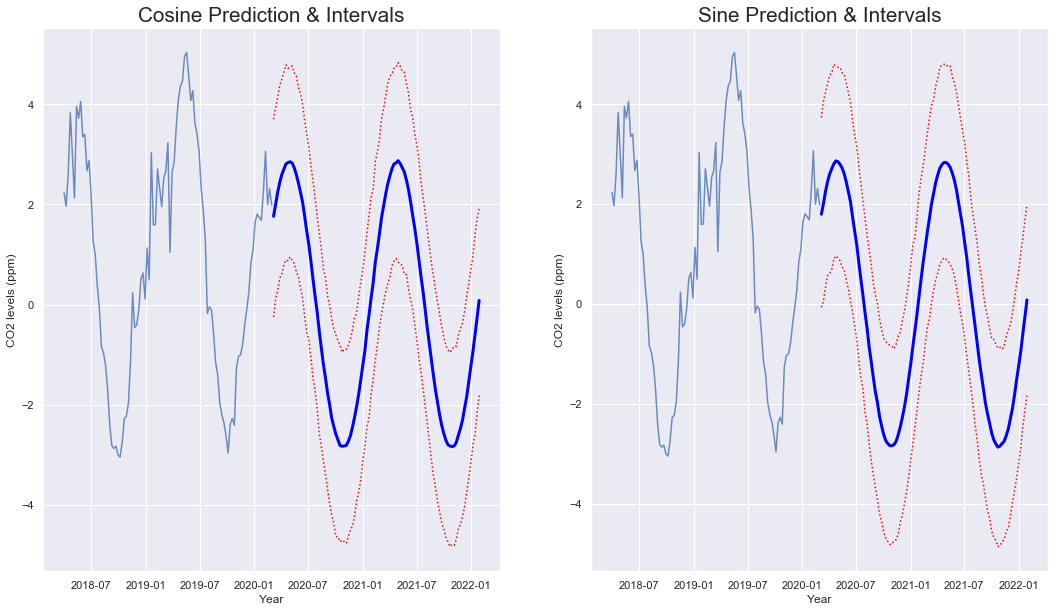

In [420]:
#Plot predictions and intervals

cosine_prediction = []
for i in cosine_samples['CO2_pred'].transpose():
    cosine_prediction.append(np.mean(i))
    
sine_prediction = [] 
for i in sine_samples['CO2_pred'].transpose():
    sine_prediction.append(np.mean(i))
    
cosine_prediction_interval = np.percentile(cosine_samples['CO2_pred'], axis=0, q=[2.5, 97.5])
sine_prediction_interval = np.percentile(sine_samples['CO2_pred'], axis=0, q=[2.5, 97.5])

plt.figure(figsize=(18,10))
plt.subplot(1, 2, 1)

#plot data
plt.plot(date[-100:], CO2_noTrend[-100:], alpha=0.8)

#plot linear model predictions
plt.plot(new_date[:100], cosine_prediction[:100], color="blue", 
         label = "Cosine Prediction", linewidth=3)

#plot linear model intervals
plt.plot(new_date[:100], cosine_prediction_interval[0,:][:100], color="red", linestyle=':')
plt.plot(new_date[:100], cosine_prediction_interval[1,:][:100], color="red", linestyle=':')

plt.title("Cosine Prediction & Intervals", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO2 levels (ppm)')

plt.subplot(1, 2, 2)
#plot data
plt.plot(date[-100:], CO2_noTrend[-100:], alpha=0.8)

#plot sine model predictions
plt.plot(new_date[:100], sine_prediction[:100], color="blue", linewidth=3)

#plot quadratic model intervals
plt.plot(new_date[:100], sine_prediction_interval[0,:][:100], color="red", linestyle=':')
plt.plot(new_date[:100], sine_prediction_interval[1,:][:100], color="red", linestyle=':')

plt.title("Sine Prediction & Intervals", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO2 levels (ppm)')

plt.show()

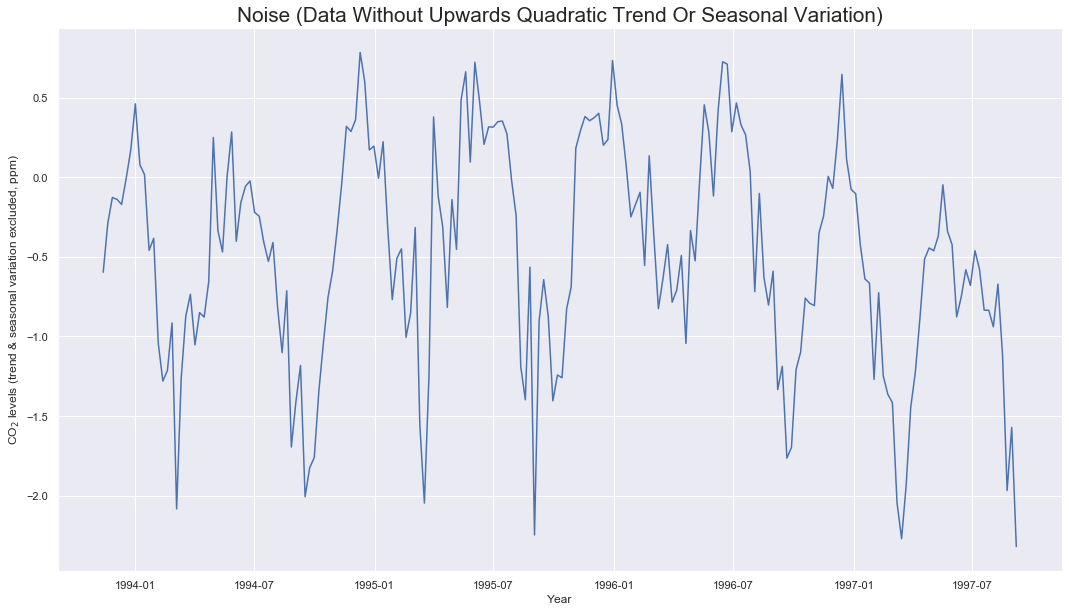

In [415]:
noise = cosine_residuals
noise_predictions = random.choices(noise, k= len(new_day))

fig5 = plt.figure(figsize=(18,10))
plt.plot(date[1800:2000], noise[1800:2000])
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (trend & seasonal variation excluded, ppm)')
plt.title("Noise (Data Without Upwards Quadratic Trend Or Seasonal Variation)", fontsize = "xx-large")

plt.show()

### Predictive Inference Using the Full Model

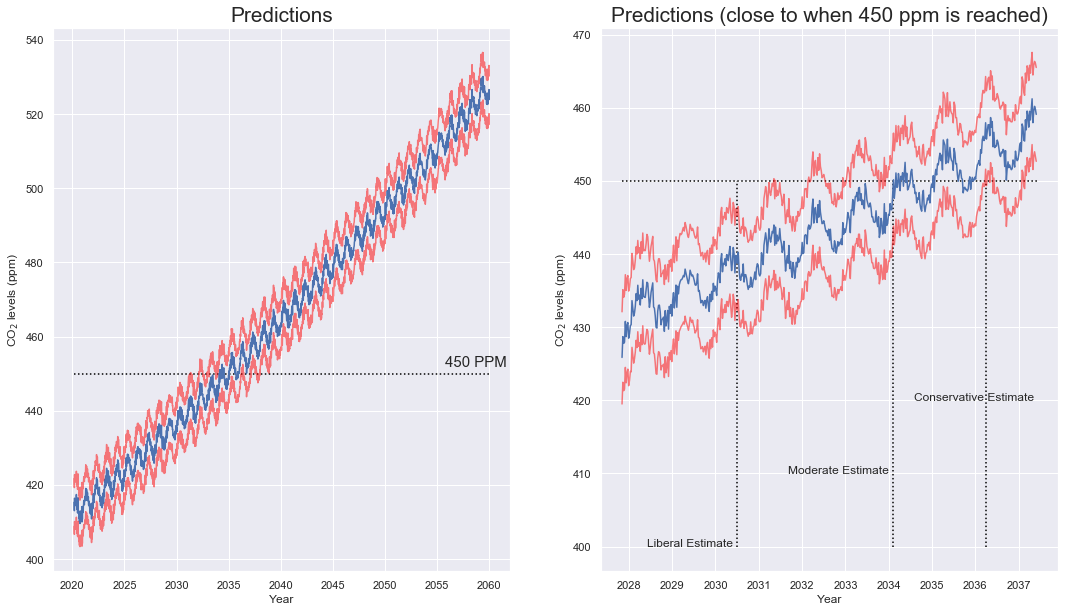

In [515]:
full_prediction = []
for i in range(len(new_date)):
    full_prediction.append(cosine_prediction[i] + quadratic_prediction[i] +  noise_predictions[i])
    
full_interval_lower = []
full_interval_upper = []

for i in range(len(new_date)):
    full_interval_lower.append(cosine_prediction_interval[0][i] + quadratic_prediction_interval[0][i] +  noise_predictions[i])
    full_interval_upper.append( cosine_prediction_interval[1][i] + quadratic_prediction_interval[1][i] +  noise_predictions[i])


fig10 = plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.title("Predictions", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.plot(new_date, full_prediction)
plt.plot(new_date, full_interval_lower, color="red", alpha=0.5)
plt.plot(new_date, full_interval_upper, color="red", alpha=0.5)
plt.hlines(450 ,xmin = new_date[0], xmax = new_date[-1], colors='k', linestyles=':', color = "black")
plt.text(new_date[-220], 452, "450 PPM ", fontsize=15)


plt.subplot(1,2,2)
plt.title("Predictions (close to when 450 ppm is reached)", fontsize = "xx-large")
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.plot(new_date[400:900], full_prediction[400:900])
plt.plot(new_date[400:900], full_interval_lower[400:900], color="red", alpha=0.5)
plt.plot(new_date[400:900], full_interval_upper[400:900], color="red", alpha=0.5)
plt.vlines(new_date[838] ,ymin = 400, ymax = 450, colors='k', linestyles=':', color = "black")
plt.vlines(new_date[727] ,ymin = 400, ymax = 450, colors='k', linestyles=':', color = "black")
plt.vlines(new_date[538] ,ymin = 400, ymax = 450, colors='k', linestyles=':', color = "black")

plt.hlines(450 ,xmin = new_date[400], xmax = new_date[900], colors='k', linestyles=':', color = "black")
plt.text(new_date[430], 400, "Liberal Estimate", fontsize=12)
plt.text(new_date[600], 410, "Moderate Estimate", fontsize=12)
plt.text(new_date[752], 420, "Conservative Estimate", fontsize=12)

plt.show()


In [507]:
#CO2 levels of 450 ppm are considered high risk for dangerous climate change. By when is
#there a strong probability that we will reach those levels? Use your model to answer this
#question, but present the results in a way that someone unfamiliar with statistics will
#understand.

for i in range(len(new_date)):
    if full_interval_lower[i] > 450:
        print("There is a very strong probability that we will reach 450 ppm in", new_date[i] )
        break
        
for i in range(len(new_date)):
    if full_prediction[i] > 450:
        print("There is a strong probability that we will reach 450 ppm in", new_date[i] )
        break
        
for i in range(len(new_date)):
    if full_interval_upper[i] > 450:
        print("There is a small probability that we will reach 450 ppm in", new_date[i] )
        break
        


There is a very strong probability that we will reach 450 ppm in 2036-03-28 00:00:00
There is a strong probability that we will reach 450 ppm in 2034-02-10 00:00:00
There is a small probability that we will reach 450 ppm in 2031-05-09 00:00:00
